In [1]:
%load_ext autoreload
%autoreload 2
# this only works on startup!
from jax import config
config.update("jax_enable_x64", True)

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '3'
from encoding_information.gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
from tqdm import tqdm
from encoding_information.information_estimation import *
from encoding_information.image_utils import *
from encoding_information.bsccm_utils import *
from bsccm import BSCCM
from jax import jit
import numpy as onp
import jax.numpy as np

bsccm = BSCCM('/home/hpinkard_waller/data/BSCCM/')

2024-01-08 13:52:50.476841: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-08 13:52:51.097999: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cublas/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_cupti/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_nvcc/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_nvrtc/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_runtime/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/pyth

Opening BSCCM
Opened BSCCM


In [5]:
channel_names = ['Brightfield', 'DPC_Right', 'LED119' ]
edge_crop = 32
num_images = 5000
num_patches = 5000
photons_per_pixel = 50
num_bootstrap_samples = 1
confidence_interval = 99
patch_size = 30

mi_means = []
mi_confidences = []
h_y_given_x_means = []
h_y_given_x_confidences = []
for channel_name in tqdm(channel_names):
    images = load_bsccm_images(bsccm, channel_name, num_images=num_images, edge_crop=edge_crop, convert_units_to_photons=True, median_filter=False, verbose=False, batch=1)
    patches = extract_patches(images, patch_size=patch_size, num_patches=num_patches, verbose=False)
    # patches = patches * photons_per_pixel / np.mean(images)
    # noisy_patches = add_noise(patches)

    rescale_fraction = photons_per_pixel / np.mean(images)
    noisy_patches = add_shot_noise_to_experimenal_data(patches, photon_fraction=rescale_fraction)

    mi_mean, mi_confidence = run_bootstrap(noisy_patches, num_bootstrap_samples=num_bootstrap_samples, confidence_interval=confidence_interval, 
                estimation_fn=lambda noisy_images: estimate_mutual_information(noisy_images=noisy_images, verbose=False), verbose=True)
    
    h_y_given_x_mean, h_y_given_x_confidence = run_bootstrap(noisy_patches, num_bootstrap_samples=num_bootstrap_samples, confidence_interval=confidence_interval,
                estimation_fn=lambda noisy_images: estimate_conditional_entropy(noisy_images), verbose=True)

    mi_means.append(mi_mean)
    mi_confidences.append(mi_confidence)
    h_y_given_x_means.append(h_y_given_x_mean)
    h_y_given_x_confidences.append(h_y_given_x_confidence)

    
mi_means = np.array(mi_means)
mi_confidences = np.array(mi_confidences)
h_y_given_x_means = np.array(h_y_given_x_means)
h_y_given_x_confidences = np.array(h_y_given_x_confidences)

100%|██████████| 3/3 [06:13<00:00, 124.57s/it]


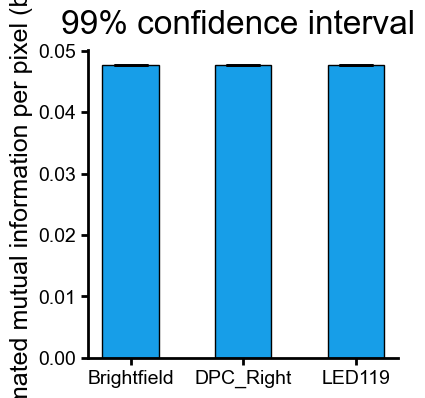

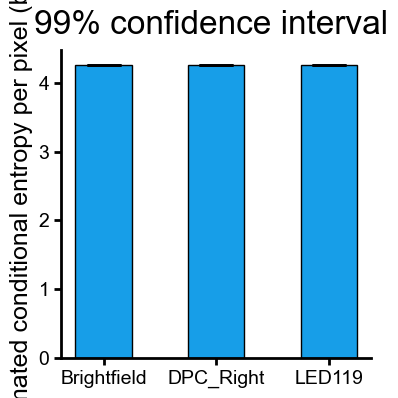

In [3]:
# set the width of the bars
bar_width = 0.35
error_kw = {'capsize': 12, 'capthick': 2}

# create a paired bar plot of results
fig, ax = plt.subplots(1, 1, figsize=(4, 4))


# create the bar plots
bar_width = 0.5
lower_errors = mi_means - mi_confidences[:, 0]
upper_errors = mi_confidences[:, 1] - mi_means

# Calculate the positions where the bars should be placed to be centered on the ticks
positions = np.arange(len(channel_names)) + 0.5 * bar_width

ax.bar(
    positions,
    mi_means,
    yerr=np.array([lower_errors, upper_errors]),
    width=bar_width,
    color=colors[0],
    edgecolor='k',
    linewidth=1,
    error_kw=error_kw
)

# add labels, title, and legend
ax.set_xticks(np.arange(len(channel_names)) + bar_width / 2, channel_names)
ax.set_ylabel('Estimated mutual information per pixel (bits)')
fig.suptitle(f'{confidence_interval}% confidence interval')
clear_spines(ax)

# make another plot for conditional entropy
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

lower_errors = h_y_given_x_means - h_y_given_x_confidences[:, 0]
upper_errors = h_y_given_x_confidences[:, 1] - h_y_given_x_means

ax.bar(
    positions,
    h_y_given_x_means,
    yerr=np.array([lower_errors, upper_errors]),
    width=bar_width,
    color=colors[0],
    edgecolor='k',
    linewidth=1,
    error_kw=error_kw
)

# add labels, title, and legend
ax.set_xticks(np.arange(len(channel_names)) + bar_width / 2, channel_names)
ax.set_ylabel('Estimated conditional entropy per pixel (bits)')
fig.suptitle(f'{confidence_interval}% confidence interval')
clear_spines(ax)

## MI vs num photons

In [3]:
channel_names = ['Brightfield', 'DPC_Right', 'LED119' ]
edge_crop = 32
num_images = 5000
num_patches = 5000
photons_per_pixel = [20, 40, 80, 160, 300]
num_bootstrap_samples = 10
confidence_interval = 99
patch_size = 20


edge_crop = 32
num_images = 1000
num_patches = 1000
photons_per_pixel = [200]
num_bootstrap_samples = 1
confidence_interval = 99
patch_size = 20
channel_names = ['Brightfield']


mi_means_by_channel_photons = {}
mi_confidences_by_channel_photons = {}
for channel_name in tqdm(channel_names):
    mi_means_by_channel_photons[channel_name] = []
    mi_confidences_by_channel_photons[channel_name] = []
    images = load_bsccm_images(bsccm, channel_name, num_images=num_images, edge_crop=edge_crop, convert_units_to_photons=True, median_filter=False, verbose=False)
    for num_photons in photons_per_pixel:
        patches = extract_patches(images, patch_size=patch_size, num_patches=num_patches, verbose=False)
        noisy_patches = add_shot_noise_to_experimenal_data(patches, num_photons / np.mean(images))
        # noisy_patches = add_noise(patches * num_photons / np.mean(images))

        mi_mean, mi_confidence = run_bootstrap(noisy_patches, num_bootstrap_samples=num_bootstrap_samples, confidence_interval=confidence_interval, 
                    estimation_fn=lambda noisy_images: estimate_mutual_information(noisy_images=noisy_images, verbose=True, use_iterative_optimization=True),
                      verbose=True)
        mi_means_by_channel_photons[channel_name].append(mi_mean)
        mi_confidences_by_channel_photons[channel_name].append(mi_confidence)
    
mi_means_by_channel_photons = {channel: np.array(v) for channel, v in mi_means_by_channel_photons.items()}
mi_confidences_by_channel_photons = {channel: np.array(v) for channel, v in mi_confidences_by_channel_photons.items()}

  0%|          | 0/1 [00:38<?, ?it/s]


KeyboardInterrupt: 

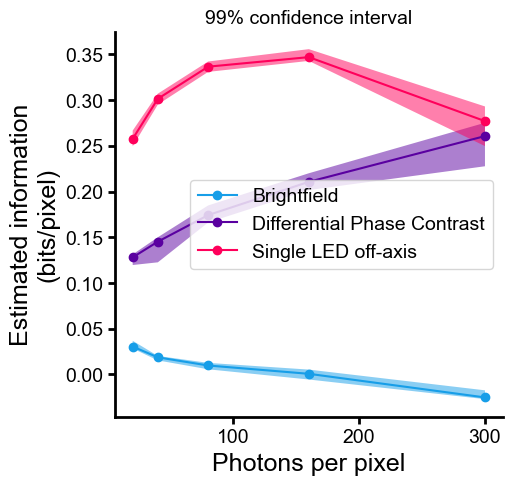

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(photons_per_pixel, mi_means_by_channel_photons['Brightfield'], '-o',
         label=get_display_channel_names('Brightfield'))
ax.fill_between(photons_per_pixel, mi_confidences_by_channel_photons['Brightfield'][:, 0], 
                mi_confidences_by_channel_photons['Brightfield'][:, 1], alpha=0.5)
ax.plot(photons_per_pixel, mi_means_by_channel_photons['DPC_Right'], '-o',
        label=get_display_channel_names('DPC_Right'))
ax.fill_between(photons_per_pixel, mi_confidences_by_channel_photons['DPC_Right'][:, 0],
                 mi_confidences_by_channel_photons['DPC_Right'][:, 1], alpha=0.5)
ax.plot(photons_per_pixel, mi_means_by_channel_photons['LED119'], '-o',
        label=get_display_channel_names('LED119'))
ax.fill_between(photons_per_pixel, mi_confidences_by_channel_photons['LED119'][:, 0], 
                mi_confidences_by_channel_photons['LED119'][:, 1], alpha=0.5)
ax.set(xlabel='Photons per pixel', ylabel='Estimated information\n(bits/pixel)')
ax.legend()
clear_spines(ax)
ax.title.set_text(f'{confidence_interval}% confidence interval')


In [ ]:
# show representative images for each channel at each photon level 
num_images = 5

for photons in photons_per_pixel:
    fig, axes = plt.subplots(3, num_images, figsize=(num_images, 3))
    for channel_idx, channel_name in enumerate(channel_names):
        images = load_bsccm_images(bsccm, channel_name, num_images=5, edge_crop=edge_crop, convert_units_to_photons=True, median_filter=False, verbose=False)
        noisy_images = add_shot_noise_to_experimenal_data(images, photons / np.mean(images))
        for i in range(num_images):
            axes[channel_idx, i].imshow(noisy_images[i])
            axes[channel_idx, i].axis('off')
    fig.suptitle(f'{photons} photons/pixel')
    